__Libraries__

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import patches
from scipy import stats
from matplotlib.patches import Patch
from sqlalchemy import create_engine
import string
import os
import re
import pwlf

__Params__

In [5]:
# plt.rcParams['savefig.dpi']= 1000
# plt.rcParams['savefig.format']= 'png'
# plt.rcParams['axes.linewidth']= 1.4
# plt.rcParams['xtick.major.size']= 6
# plt.rcParams['ytick.major.size']= 6
# plt.rcParams['xtick.major.width']= 1.5
# plt.rcParams['ytick.major.width']= 1.5
# plt.rcParams['axes.titleweight']= 'bold'
# plt.rcParams['axes.labelweight']= 'bold'
# # plt.rcParams['font.weight']= 'bold'
# plt.rcParams['legend.frameon']= False
# plt.rcParams['figure.constrained_layout.use']= True
# plt.rcParams['axes.spines.top']= True
# plt.rcParams['axes.spines.right']= True
# plt.rcParams['axes.spines.bottom']= True
# plt.rcParams['axes.spines.left']= True
# # plt.rcParams['axes.grid']= False
# plt.rcParams['font.size'] = 11 
# plt.rcParams['axes.titlesize'] = 12 
# plt.rcParams['axes.labelsize'] = 10  
# plt.rcParams['xtick.labelsize'] = 12 
# plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams['legend.fontsize'] = 8

----------------------------------------------------------------------------------------------------------------

__Inputs__

In [8]:
cell_count_threshold= 50

p_value_threshold= 0.0001

perc_sign_diff_timepoints_thre= 0.80

#paths to files (if applicable)
strains= r"C:\Users\Jakub\Desktop\figures\Figure_3\Fig3_data\96database_complete.xlsx" #file, path to strain-collection database
experimental_data= r"C:\Users\Jakub\Desktop\figures\Figure_3\Fig3_data\all_plates(summary by well)" #folder

#mysql server connection parameters
username= 'root'
password= 'poef.qve5353'
hostname= '127.0.0.1'
port= '3306'

---------------------------------------------------------------------------------------

__Data Load and Preprocess__

* __from files__

In [12]:
def data_load_and_preprocess(path_strain_db, path_experimental_data, initial_delay, frequency, initial_timepoints_skipped):
    
    #database of strains and their positions in well plates
    strain_db= pd.read_excel(path_strain_db).iloc[:, 1:]
    
    #experimental data, all plates loaded from a folder and concatenated to s single dataframe, pre-processing (timepoints, column selection, column names, proportion of the cells with aggregates calculated) applied
    data_folder= path_experimental_data
    data= pd.DataFrame() #empty dataframe
    for plate in os.listdir(data_folder):
        plate_name= plate[6:-4] #file name with '.csv' removed
        plate_path= os.path.join(data_folder, plate) # path to a single plate
        plate_data= pd.read_csv(plate_path,
                                usecols= ['WELL LABEL', 'T', 'Cells Count wv1', 'Granules Cells with Org wv2', 'Granules Org per Cell wv2', 'Granules Area wv2'],
                                converters= {'WELL LABEL':lambda x: x.replace(' - ', '0') if len(x) == 5 else x.replace(' - ', '')}) #plate data load
        plate_data= plate_data.assign(Timepoint_minutes= plate_data['T'] * frequency - (frequency - initial_delay),
                                      Timepoint_hours= lambda x: x['Timepoint_minutes']/60,
                                      Percentage= (plate_data['Granules Cells with Org wv2']/plate_data['Cells Count wv1'])*100,
                                      Plate= plate_name)
        plate_data.columns= ['Well', 'Timepoint', 'NumberOfCells', 'NumberOfCellsContainingAggregates', 'AverageNumberOfAggregatesPerCell', 'AverageSizeOfSingleAggregates', 'TimepointMinutes', 'TimepointHours', 'PercentageOfCellsContainingAggregates', 'Plate']    
        plate_data= plate_data.reindex(columns= ['Well', 'Timepoint', 'TimepointHours', 'TimepointMinutes', 'NumberOfCells', 'NumberOfCellsContainingAggregates','PercentageOfCellsContainingAggregates', 'AverageNumberOfAggregatesPerCell', 'AverageSizeOfSingleAggregates', 'Plate'])
        data= pd.concat([data, plate_data], ignore_index= True) #appending to a common dataframe
    data= data.loc[data.Timepoint > initial_timepoints_skipped]
    
    # converting the well-labels from 384- to 96-format
    # needed for proper assignment of mutation labels from database (based on plate-well in 96 format)
    UL= [x + '0' + str(y) if (y < 10) else x + str(y) for x in list(string.ascii_uppercase)[:8] for y in list(range(1, 13))]
    UR= [x + str(y) for x in list(string.ascii_uppercase)[:8] for y in list(range(13, 25))]
    LL= [x + '0' + str(y) if (y < 10) else x + str(y) for x in list(string.ascii_uppercase)[8:16] for y in list(range(1, 13))]
    LR= [x + str(y) for x in list(string.ascii_uppercase)[8:16]  for y in list(range(13, 25))]
    _384plate= UL + UR + LL + LR
    
    _96plate_section= [x + '0' + str(y) if (y < 10) else x + str(y) for x in list(string.ascii_uppercase)[:8] for y in list(range(1, 13))]
    _96plate= _96plate_section + _96plate_section + _96plate_section + _96plate_section
    
    conversion_dict= dict(zip(_384plate, _96plate))
    data= data.assign(Well= data.Well.map(conversion_dict))
    
    # assigning labels from the strain-collection database 
    data= data.merge(strain_db.loc[:, ['Plate', 'Well', 'ORF', 'Mutation']], how= 'left', on= ['Plate', 'Well'])
    data= data.assign(ORF= np.where(data.Mutation=='WT control', '-', data.ORF), #unifies labelling with SQL db
                      Mutation = np.where(data.Mutation=='WT control', 'wt control', data.Mutation),
                      Gene= data.Mutation.apply(lambda x: '-' if x=='WT control' else x.split('-')[0].upper())) #unifies labelling with SQL db
    
    #reorder columns to unify with sql db output
    data= data.reindex(columns= ['Plate', 'Well', 'ORF', 'Gene', 'Mutation', 'Timepoint', 'TimepointMinutes', 'TimepointHours', 'NumberOfCells', 'NumberOfCellsContainingAggregates', 'PercentageOfCellsContainingAggregates', 'AverageNumberOfAggregatesPerCell', 'AverageSizeOfSingleAggregates'])
    
    data= data.assign(PercentageOfCellsContainingAggregates= round(data.PercentageOfCellsContainingAggregates, 4),
                      AverageNumberOfAggregatesPerCell= round(data.AverageNumberOfAggregatesPerCell, 6),
                      AverageSizeOfSingleAggregates= round(data.AverageSizeOfSingleAggregates, 6),
                      TimepointHours= round(data.TimepointHours, 5))
    
    #dtype coercion
    data= data.astype({'Timepoint':'int32', 'NumberOfCells':'int32', 'NumberOfCellsContainingAggregates':'int32'})
    
    return data

* __from database__

In [14]:
def data_load_from_db(initial_timepoints_skipped, username=username, password=password, hostname=hostname, port=port):
    
    #mysql server connection
    connection_string = f"mysql+pymysql://{username}:{password}@{hostname}:{port}/hc_microscopy_data_v2"
    engine = create_engine(connection_string) 
    
    #query to obtain the desired data
    query = "call p_ts_screen_first_round_all_data (%s)"
    param1= initial_timepoints_skipped
    data= pd.read_sql(query, engine, params= (param1,))
    
    #unify the table layout with load 'from files'
    data= data.iloc[:, 1:]
    data.columns= ['Plate', 'Well', 'ORF', 'Gene', 'Mutation', 'Timepoint', 'TimepointMinutes', 'TimepointHours', 'NumberOfCells', 'NumberOfCellsContainingAggregates', 'PercentageOfCellsContainingAggregates', 'AverageNumberOfAggregatesPerCell', 'AverageSizeOfSingleAggregates']
    data= data.sort_values(['Plate', 'Well', 'Timepoint'], ascending= True)
    data=data.reset_index(drop= True)
    
    #unify 0/NaNs with load 'from files'
    data= data.assign(AverageNumberOfAggregatesPerCell= np.where(data.PercentageOfCellsContainingAggregates.isna(), np.NaN, data.AverageNumberOfAggregatesPerCell),
                      AverageSizeOfSingleAggregates= np.where(data.PercentageOfCellsContainingAggregates.isna(), np.NaN, data.AverageSizeOfSingleAggregates))
    data= data.assign(AverageSizeOfSingleAggregates= np.where(data.PercentageOfCellsContainingAggregates== 0, np.NaN, data.AverageSizeOfSingleAggregates))
    
    #dtype coercion    
    data= data.astype({'Timepoint':'int32', 'NumberOfCells':'int32', 'NumberOfCellsContainingAggregates':'int32'})
    
    return data

* __data load__

In [16]:
# 'db' to load from mysql database, 'raw file' to load from a file
def data_load(source):
    if source=='db':
        data= data_load_from_db(3)
        return data
    elif source=='raw file':
        data= data_load_and_preprocess(strains, experimental_data, 6.5, 6.5, 3)
        return data
    else:
        raise ValueError(f"Invalid source input: '{source}'. Expected: 'db' or 'raw file'.")

In [17]:
data= data_load('raw file')

In [18]:
data.head()

,Plate,Well,ORF,Gene,Mutation,Timepoint,TimepointMinutes,TimepointHours,NumberOfCells,NumberOfCellsContainingAggregates,PercentageOfCellsContainingAggregates,AverageNumberOfAggregatesPerCell,AverageSizeOfSingleAggregates
0,1A,A01,-,-,wt control,4,26.0,0.43333,27,3,11.1111,0.111111,0.221108
1,1A,A01,-,-,wt control,5,32.5,0.54167,24,5,20.8333,0.208333,0.192660
2,1A,A01,-,-,wt control,6,39.0,0.65000,26,9,34.6154,0.615385,0.187347
3,1A,A01,-,-,wt control,7,45.5,0.75833,25,7,28.0000,0.560000,0.197821
4,1A,A01,-,-,wt control,8,52.0,0.86667,22,12,54.5455,1.318182,0.223884


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94031 entries, 0 to 94030
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Plate                                  94031 non-null  object 
 1   Well                                   94031 non-null  object 
 2   ORF                                    94031 non-null  object 
 3   Gene                                   94031 non-null  object 
 4   Mutation                               94031 non-null  object 
 5   Timepoint                              94031 non-null  int32  
 6   TimepointMinutes                       94031 non-null  float64
 7   TimepointHours                         94031 non-null  float64
 8   NumberOfCells                          94031 non-null  int32  
 9   NumberOfCellsContainingAggregates      94031 non-null  int32  
 10  PercentageOfCellsContainingAggregates  90923 non-null  float64
 11  Av

In [20]:
data.describe()

,Timepoint,TimepointMinutes,TimepointHours,NumberOfCells,NumberOfCellsContainingAggregates,PercentageOfCellsContainingAggregates,AverageNumberOfAggregatesPerCell,AverageSizeOfSingleAggregates
count,94031.000000,94031.00000,94031.000000,94031.000000,94031.000000,90923.000000,90923.000000,89512.000000
mean,28.000000,182.00000,3.033333,127.283183,85.008604,64.402317,1.479781,0.349081
std,14.142211,91.92437,1.532073,84.725308,62.416971,18.818810,0.663653,0.082297
min,4.000000,26.00000,0.433330,0.000000,0.000000,0.000000,0.000000,0.025350
25%,16.000000,104.00000,1.733330,63.000000,38.000000,55.223900,1.003937,0.304005
50%,28.000000,182.00000,3.033330,116.000000,75.000000,68.613100,1.464286,0.352897
75%,40.000000,260.00000,4.333330,181.000000,121.000000,78.125000,1.945135,0.394188
max,52.000000,338.00000,5.633330,851.000000,436.000000,100.000000,5.000000,2.019550


-------------------------------------------------------------------------------------------

__Filtering based on cell counts (cc)__

* __cc-based filter__

>- _wells with cell count below the set threshold in the initital timepoint filtered out_

In [25]:
def cell_count_filter(dataset, threshold= cell_count_threshold):
    first_timepoint_cell_count_filter= list(dataset.loc[(dataset.Timepoint==dataset.Timepoint.min())&
                                                        (dataset.NumberOfCells>=threshold), 'Well'])
    dataset= dataset.loc[dataset.Well.isin(first_timepoint_cell_count_filter)]
    return dataset

In [26]:
data_cc_filtered= data.groupby('Plate').apply(lambda x: cell_count_filter(x)).reset_index(drop= True) #applying the filter on data from individual plates

* __cc visualisation: plate-well-cc pivot, before and after filtering__

>- _initital timpoint cell counts before and after filtering_
>- _below-threshold wells labelled with red_
>- _wells removed from the data during filtering labeled with white_

In [29]:
def cell_counts(original_dataset, cc_filtered_dataset, cc_threshold):
    
    nf_data= original_dataset.loc[(original_dataset.Timepoint==original_dataset.Timepoint.min())]
    nf_data= nf_data.pivot_table(index= 'Well',
                                 columns= 'Plate',
                                 values= 'NumberOfCells')
    f_data= cc_filtered_dataset.loc[(cc_filtered_dataset.Timepoint==cc_filtered_dataset.Timepoint.min())]
    f_data= f_data.pivot_table(index= 'Well',
                               columns= 'Plate',
                               values= 'NumberOfCells')
    
    
    fig, ax= plt.subplots(1, 2, figsize= (25, 25), constrained_layout= True)
    cmap_above_thr = sns.color_palette(["#ADD8E6"])
    cmap_below_thr = sns.color_palette(["#FF474C"])

    sns.heatmap(nf_data,
                ax= ax[0],
                cmap= cmap_above_thr,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.0f',
                mask= nf_data < cc_threshold)
    sns.heatmap(nf_data,
                ax= ax[0],
                cmap= cmap_below_thr,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.0f',
                mask= nf_data >= cc_threshold)
    
    sns.heatmap(f_data,
                ax= ax[1],
                cmap= cmap_above_thr,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.0f',
                mask= f_data < cc_threshold)     
                
    ax[0].set_xlabel('Plate', fontsize= 12, weight= 'bold')
    ax[0].set_ylabel('Well', fontsize= 12, weight= 'bold')
    ax[0].set_xlim(0,len(nf_data.columns)+0.1)
    ax[0].set_ylim(-0.10, len(nf_data))
    ax[0].set_title('before cc filtering',
                    fontsize= 12,
                    weight= 'bold')
    
    ax[1].set_xlabel('Plate', fontsize= 12, weight= 'bold')
    ax[1].set_ylabel('Well', fontsize= 12, weight= 'bold')
    ax[1].set_xlim(0,len(f_data.columns)+0.1)
    ax[1].set_ylim(-0.10, len(f_data))
    ax[1].set_title('cc filtered',
                    fontsize= 12,
                    weight= 'bold');

In [30]:
# cell_counts(data, data_cc_filtered, cell_count_threshold)

* __visualising the proportions of mutant/control wells remaining after cc-based filtering, for each plate__

In [32]:
def perc_wells_remaining(original_dataset, cc_filtered_dataset):
    #calculation
    total_controls= original_dataset.loc[original_dataset.Mutation=='wt control', ['Plate', 'Well']].groupby('Plate').nunique().reset_index()
    total_controls.columns= ['Plate', 'TotalControls']

    analysed_controls= cc_filtered_dataset.loc[cc_filtered_dataset.Mutation=='wt control', ['Plate', 'Well']].groupby('Plate').nunique().reset_index()
    analysed_controls.columns= ['Plate', 'AnalysedControls']

    total_mutants= original_dataset.loc[original_dataset.Mutation!='wt control', ['Plate', 'Well']].groupby('Plate').nunique().reset_index()
    total_mutants.columns= ['Plate', 'TotalMutants']

    analysed_mutants= cc_filtered_dataset.loc[cc_filtered_dataset.Mutation!='wt control', ['Plate', 'Well']].groupby('Plate').nunique().reset_index()
    analysed_mutants.columns= ['Plate', 'AnalysedMutants']

    no_of_strains= total_controls.merge(analysed_controls, how= 'left', on= 'Plate').merge(total_mutants, how= 'left', on= 'Plate').merge(analysed_mutants, how= 'left', on= 'Plate')

    no_of_strains= no_of_strains.assign(AnalysedControlPercentage= no_of_strains.AnalysedControls/no_of_strains.TotalControls*100,
                                        AnalysedMutantsPercentage= no_of_strains.AnalysedMutants/no_of_strains.TotalMutants*100)

    #visualisation
    fig, ax= plt.subplots(figsize= (15,10))
    x= list()
    width= 0.35
    for i, plate in enumerate(list(no_of_strains.Plate)):
        a= i+1
        control_value= no_of_strains.loc[no_of_strains.Plate==plate, 'AnalysedControlPercentage'].iloc[0]
        mutant_value= no_of_strains.loc[no_of_strains.Plate==plate, 'AnalysedMutantsPercentage'].iloc[0]
        ax.bar(a-width/2,
               control_value,
               width=width,
               color= '#FF474C',
               label= '% of control wells analysed',
               edgecolor= 'black',
               lw= .6)
        ax.bar(a+width/2,
               mutant_value,
               width=width,
               color= '#ADD8E6',
               label= '% of mutant wells analysed',
               edgecolor= 'black',
               lw= .6)
        x.append(a)

    ax.set_xticks(x)
    ax.set_xticklabels(no_of_strains.Plate)
    ax.set_ylim(0,115)
    ax.set_xlabel('Plate', weight= 'bold')
    ax.set_ylabel('Percentage', weight= 'bold')
    ax.set_title('Percentage of wells left for analysis after filtering',
                 weight= 'bold')
    ax.axhline(100, ls= '-', lw= .66, color= 'gray')
    ax.axhline(70, ls= '--', lw= .66, color= 'gray')

    legend_elements = [Patch(facecolor='#FF474C', label='control wells'),
                       Patch(facecolor='#ADD8E6', alpha=0.5, label='mutant wells')]
    plt.legend(handles=legend_elements,
               frameon= False,
               ncol= 2);

In [33]:
# perc_wells_remaining(data, data_cc_filtered)

-----------------------------------

__Filling potential missing values by linear interpolation__

In [36]:
def fillnan(dataset):
    if dataset.isna().sum().sum() > 0:
        print(f'{dataset.isna().sum().sum()} missing values filled in by linear interpolation')
        dataset= dataset.interpolate(method= 'linear')
        return dataset
    else:
        print('No missing values detected!')
        return dataset

In [37]:
data_cc_filtered_nan_filled= fillnan(data_cc_filtered)

33 missing values filled in by linear interpolation


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

__Spliting 'control' and 'mutant' data__

In [40]:
control_data= data_cc_filtered_nan_filled.loc[data_cc_filtered_nan_filled.Mutation=='wt control'].reset_index(drop= True)
# control_data

In [41]:
mutant_data= data_cc_filtered_nan_filled.loc[data_cc_filtered_nan_filled.Mutation!='wt control'].reset_index(drop= True)
# mutant_data

------------------------------------------------------------------------------------------------------------------------------------------------------------------

__Removing all the aux. controls from the mutant data__

In [44]:
aux_mut_ctrls= ['arg5,6', 'ade5,7', 'lys5', 'trp2']

In [45]:
mutant_data= mutant_data.loc[~mutant_data.Mutation.isin(aux_mut_ctrls)]

-----------------------------------------------------------------------------------------------------

__Exporting the mutant and control data__

In [48]:
# control_data.to_csv(r"C:\Users\Jakub\Desktop\control_data.csv")
# mutant_data.to_csv(r"C:\Users\Jakub\Desktop\mutant_data.csv")

------------------------------------------------------------

__Re-arranging control data: list of all values for particular Plate-Timepoint-Parameter (used later for statistical analysis: one-sample ttest)__

In [51]:
control_data_grouped= control_data.groupby(['Plate', 'Timepoint', 'TimepointHours', 'TimepointMinutes'])[['PercentageOfCellsContainingAggregates', 'AverageNumberOfAggregatesPerCell', 'AverageSizeOfSingleAggregates']].agg({'PercentageOfCellsContainingAggregates':list,
                                                                                                                                                                                                                              'AverageNumberOfAggregatesPerCell':list,
                                                                                                                                                                                                                              'AverageSizeOfSingleAggregates':list}).reset_index()
control_data_grouped.columns= ['Plate', 'Timepoint', 'TimepointHours', 'TimepointMinutes', 'PercentageControlData', 'NumberControlData', 'SizeControlData']
# control_data_grouped

--------------------------------------------------------------------------------------------------------------

__Outlier removal__

In [54]:
def outlier_removal(data, z_threshold= 2, iqr_threshold= 1.5): #thresholds: +/-2 for Z-score, +/-1.5* for IQR
    data= pd.DataFrame(data)
    stat, p_value = stats.shapiro(data.iloc[:, 0]) #H0: data is normally distributed
    if p_value > 0.05: #p-value above 0.05: can't reject H0, normal distribution
        data= data.assign(ZScore= (data.iloc[:,0]-data.iloc[:,0].mean())/data.iloc[:,0].std())
        data= data.loc[(data.ZScore<=z_threshold)&(data.ZScore>=-z_threshold)]
        return list(data.iloc[:, 0])
    else: #p-values below 0.05: reject H0, non-normal distribution
        q3= np.quantile(data, 0.75)
        q1= np.quantile(data, 0.25)
        iqr= q3-q1
        data= data.assign(WithinIQR= (data.iloc[:,0]>=q1-iqr_threshold*iqr)&(data.iloc[:,0]<=q3+iqr_threshold*iqr))
        data= data.loc[data.WithinIQR==True]
        return list(data.iloc[:, 0])

In [55]:
control_data_grouped_cleaned= control_data_grouped.assign(PercentageControlData= control_data_grouped.PercentageControlData.apply(lambda x: outlier_removal(x)),
                                                          NumberControlData= control_data_grouped.NumberControlData.apply(lambda x: outlier_removal(x)),
                                                          SizeControlData= control_data_grouped.SizeControlData.apply(lambda x: outlier_removal(x)))
# control_data_grouped_cleaned

----------------------------------------------------

__Averaging control dataset__

In [58]:
def control_data_avg(ctrl_dataset):
    #averaging list-based data
    control_data= ctrl_dataset.assign(PercentageControlData= ctrl_dataset.PercentageControlData.apply(lambda x: np.mean(x)),
                                      NumberControlData= ctrl_dataset.NumberControlData.apply(lambda x: np.mean(x)),
                                      SizeControlData= ctrl_dataset.SizeControlData.apply(lambda x: np.mean(x)))

    return control_data

In [59]:
#control data used later (see hit quantification)
control_data_averaged_per_plate= control_data_avg(control_data_grouped_cleaned)
# control_data_averaged_per_plate

------------------------------------------------------------------------

__Idetifying breakponts in scatter plot (number-size) to define timeranges for individual stages__

In [62]:
data_for_stage_identification= control_data_averaged_per_plate.loc[:, ['TimepointMinutes', 'NumberControlData', 'SizeControlData']] #selected columns from control data (averaged per plate)
# data_for_breakpoints.head()

In [63]:
def stage_bins(data, step= 2, minimal_formation_length= 30, maximal_formation_end= 120, minimal_rf_length= 60, maximal_rf_end= 300):
    
    potential_formation_end= np.arange(data.TimepointMinutes.min() + minimal_formation_length, maximal_formation_end + step, step)
    f_rf_end_combinations= [[x, i] for x in potential_formation_end for i in np.arange(x + minimal_rf_length, maximal_rf_end + step, step)]   
    
    break_points_df= pd.DataFrame(columns= ['f_end', 'rf_end', 'f_cc', 'rf_cc', 'c_cc']) #empty df
    
    for breakpoints in f_rf_end_combinations:
        f_end= breakpoints[0]
        rf_end= breakpoints[1]

        formation_data= data.loc[data.TimepointMinutes <= f_end]
        relocation_and_fusion_data= data.loc[(data.TimepointMinutes > f_end) & ((data.TimepointMinutes <= rf_end))]
        clearance_data= data.loc[data.TimepointMinutes > rf_end]

        formation_cc= round(formation_data.NumberControlData.corr(formation_data.SizeControlData, method= 'pearson', min_periods= 2), 2)
        relocation_and_fusion_cc= round(relocation_and_fusion_data.NumberControlData.corr(relocation_and_fusion_data.SizeControlData, method= 'pearson', min_periods= 2), 2)    
        clearance_cc= round(clearance_data.NumberControlData.corr(clearance_data.SizeControlData, method= 'pearson', min_periods= 2), 2)

        single_row= pd.DataFrame([[f_end, rf_end, formation_cc, relocation_and_fusion_cc, clearance_cc]], columns= ['f_end', 'rf_end', 'f_cc', 'rf_cc', 'c_cc'])
        break_points_df= pd.concat([break_points_df, single_row], axis= 0)
    
    # total_dev=∣x−1∣+∣x+1∣+∣x−1∣
    break_points_df= break_points_df.assign(total_dev= np.abs(break_points_df.f_cc - 1) + np.abs(break_points_df.rf_cc + 1) + np.abs(break_points_df.c_cc - 1) )
    
    break_points_df= break_points_df.loc[break_points_df.total_dev==break_points_df.total_dev.min()]
    
    #average the timepoints (in case of multiple entries for the minimu total_dev)
    break_points_df= break_points_df.loc[:, ['f_end', 'rf_end']].mean()
    
    stage_bins= [0, break_points_df.loc['f_end'], break_points_df.loc['rf_end'], 1000]
    
    return stage_bins

In [64]:
stage_bins= stage_bins(data_for_stage_identification)
stage_bins

[0, 62.0, 300.0, 1000]

In [65]:
def stages_visualisation(data, stage_bins):
    
    data= data.assign(Stage= pd.cut(data.TimepointMinutes,
                                    bins= stage_bins,
                                    labels= ['formation', 'relocation & fusion', 'clearance']))
    

    fig, ax= plt.subplots()

    x= data.loc[data.Stage=='formation', 'NumberControlData']
    y= data.loc[data.Stage=='formation', 'SizeControlData']
    cc= round(x.corr(y, method= 'pearson', min_periods= 2), 2)
    ax.scatter(x,
                y,
                edgecolor= 'black',
                lw=.15,
                color= '#DFE9F5',
                label= f'formation, cc: {cc}')
    m, b= np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
             color= '#00527C',
             linewidth= 2.5)

    x= data.loc[data.Stage=='relocation & fusion', 'NumberControlData']
    y= data.loc[data.Stage=='relocation & fusion', 'SizeControlData']
    cc= round(x.corr(y, method= 'pearson', min_periods= 2), 2)
    ax.scatter(x,
                y,
                edgecolor= 'black',
                lw=.15,
                color= '#FEE7CC',
                label= f'relocation & fusion, cc: {cc}')
    m, b= np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
             color= '#FF781F',
             linewidth= 2.5)

    x= data.loc[data.Stage=='clearance', 'NumberControlData']
    y= data.loc[data.Stage=='clearance', 'SizeControlData']
    cc= round(x.corr(y, method= 'pearson', min_periods= 2), 2)
    ax.scatter(x,
                y,
                edgecolor= 'black',
                lw=.15,
                color= '#D6FED2',
                label= f'clearance, cc: {cc}')
    m, b= np.polyfit(x, y, 1)
    ax.plot(x, m*x+b,
             color= '#0C8001',
             linewidth= 2.5)
    ax.legend(loc= 'lower right')

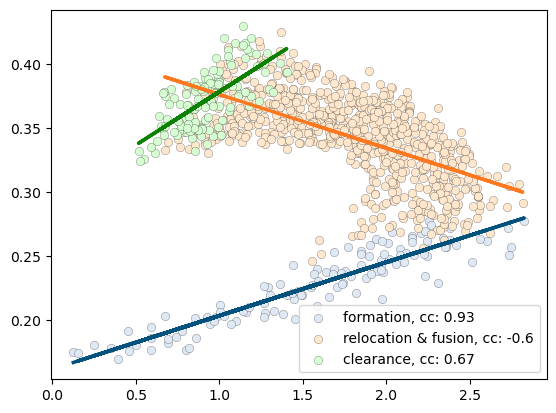

In [66]:
stages_visualisation(data_for_stage_identification, stage_bins)

-----------------------------------------------------------------------------------------------------

__Adding stages to control dataset__

In [69]:
def control_data_stages(ctrl_dataset, stage_bins):
    #adding stage column
    ctrl_dataset= ctrl_dataset.assign(Stages= pd.cut(ctrl_dataset.TimepointMinutes, 
                                                     bins= stage_bins,
                                                     labels= ['Formation', 'Relocation & Fusion', 'Clearance']))
    return ctrl_dataset

In [70]:
#control data used later (see hit quantification)
control_data_averaged_per_plate= control_data_stages(control_data_averaged_per_plate, stage_bins)
# control_data_averaged_per_plate

------------------------------------------------------------------------------------------

__Statistical analysis__

* __one-sample t-test:__ mutant value of particular parameter and timepoint compared to all corresponding control values from a particular plate (and timepoint)

In [74]:
def one_sample_ttest(mut_value, ctrl_values):
    t_stat, p_value = stats.ttest_1samp(ctrl_values, mut_value)
    return p_value

def statistical_analysis(control_dataset, mutant_dataset, p_value_thr):
    #merging ctrl and mut datasets
    data= mutant_dataset.merge(control_dataset.loc[:, ['Plate', 'Timepoint', 'PercentageControlData', 'NumberControlData', 'SizeControlData']], how= 'left', on= ['Plate', 'Timepoint'])
    #one-sample t-test for each parameter
    data= data.assign(PercentagePValue= data.apply(lambda x: one_sample_ttest(x['PercentageOfCellsContainingAggregates'], x['PercentageControlData']), axis= 1),
                      NumberPValue= data.apply(lambda y: one_sample_ttest(y['AverageNumberOfAggregatesPerCell'], y['NumberControlData']), axis= 1),
                      SizePValue= data.apply(lambda z: one_sample_ttest(z['AverageSizeOfSingleAggregates'], z['SizeControlData']), axis= 1))
    #assigning significance symbols
    data= data.assign(PercentageSignificance= np.where(data.PercentagePValue<p_value_thr, '*', ''),
                      NumberSignificance= np.where(data.NumberPValue<p_value_thr, '*', ''),
                      SizeSignificance= np.where(data.SizePValue<p_value_thr, '*', ''))
    
    #dropping unnecessary columns, reordering the remaining columns
    data= data.drop(['PercentageControlData', 'NumberControlData', 'SizeControlData', 'NumberOfCells', 'NumberOfCellsContainingAggregates'], axis=1)    
    data= data.reindex(columns= ['Well', 'Plate', 'ORF','Mutation','Timepoint', 'TimepointHours', 'TimepointMinutes','PercentageOfCellsContainingAggregates','PercentagePValue', 'PercentageSignificance','AverageNumberOfAggregatesPerCell','NumberPValue', 'NumberSignificance','AverageSizeOfSingleAggregates','SizePValue', 'SizeSignificance'])    
    
    return data

In [75]:
data= statistical_analysis(control_data_grouped_cleaned, mutant_data, p_value_threshold)

-----------------------------------------------------------------------------------------------------

__Adding Stage column and MutantID column__

In [78]:
def add_stage_id_column(dataset, stage_bins):
    ##assigning a unique identifier to every mutation based on mutation-plate-well (some mutations present in collection in multiple copies)
    dataset= dataset.assign(MutationID= dataset.Mutation + '-' + dataset.Plate + '-' + dataset.Well)
    
    ##adding stage column
    dataset= dataset.assign(Stage= pd.cut(dataset.TimepointMinutes, 
                                   bins= stage_bins,
                                   labels= ['Formation', 'Relocation & Fusion', 'Clearance']))
    return dataset

In [79]:
data= add_stage_id_column(data, stage_bins)
# data

--------------------------------------------------

__Selection of hits__

* __hit selection__

In [83]:
#function returs pivot table mutant as index-stages as columns with True/False values, True if mutant differs significantly from the control in particular stage (based on a number of significantly different timepoints)/False if not
#returns three table: indexed as [0] for selection based on percentage of cells containing aggregates/[1] for average number of aggregates per cell and [2] for average size of a single aggregate 
def hit_selection(dataset, stage_bins, perc_threshold_significance):
    
    ##calculating the threshold number of significantly different timepoints for each stage
    stage_lenghts= pd.DataFrame({'Minutes':dataset.TimepointMinutes.unique()})
    stage_lenghts= stage_lenghts.assign(Stage= pd.cut(stage_lenghts.Minutes, 
                                        bins= stage_bins,
                                        labels= ['Formation', 'Relocation & Fusion', 'Clearance']))
    #calculate the lenght of each stage (no of timepoints)
    formation_length= len(stage_lenghts.loc[stage_lenghts.Stage=='Formation'])
    rf_length= len(stage_lenghts.loc[stage_lenghts.Stage=='Relocation & Fusion'])
    clearance= len(stage_lenghts.loc[stage_lenghts.Stage=='Clearance'])
    #calculate the minimum number of significantly different timepoints (from corresponding WT) for a mutant to be considered a hit
    formation_length_threshold= len(stage_lenghts.loc[stage_lenghts.Stage=='Formation'])*perc_threshold_significance
    rf_length_threshold= len(stage_lenghts.loc[stage_lenghts.Stage=='Relocation & Fusion'])*perc_threshold_significance
    clearance_threshold= len(stage_lenghts.loc[stage_lenghts.Stage=='Clearance'])*perc_threshold_significance
    
    ##hits based on percentage of cells containing aggregates/average size of a single aggregate and average nbumber of aggregates per cell
    #calculating the number of significantly different timepoints for each mutant-stage
    hits_percentage= dataset.loc[dataset.PercentageSignificance=='*', ['MutationID', 'Timepoint', 'PercentageSignificance', 'Stage']]
    hits_percentage= hits_percentage.pivot_table(index= 'MutationID',
                                                 columns= 'Stage',
                                                 values= 'PercentageSignificance',
                                                 aggfunc= 'count')
    hits_number= dataset.loc[dataset.NumberSignificance=='*', ['MutationID', 'Timepoint', 'NumberSignificance', 'Stage']]
    hits_number= hits_number.pivot_table(index= 'MutationID',
                                         columns= 'Stage',
                                         values= 'NumberSignificance',
                                         aggfunc= 'count')
    hits_size= dataset.loc[dataset.SizeSignificance=='*', ['MutationID', 'Timepoint', 'SizeSignificance', 'Stage']]
    hits_size= hits_size.pivot_table(index= 'MutationID',
                                     columns= 'Stage',
                                     values= 'SizeSignificance',
                                     aggfunc= 'count')
    
    #comparing to thresholds: results in a boolean table, True: mutant differs significantly in a particular stage, False: mutant does not differ significantly in a particular stage
    hits_percentage_boolean= hits_percentage.copy()
    hits_percentage_boolean['Formation']= hits_percentage_boolean['Formation']>= formation_length_threshold
    hits_percentage_boolean['Relocation & Fusion']= hits_percentage_boolean['Relocation & Fusion']>= rf_length_threshold
    hits_percentage_boolean['Clearance']= hits_percentage_boolean['Clearance']>= clearance_threshold
    
    hits_number_boolean= hits_number.copy()
    hits_number_boolean['Formation']= hits_number_boolean['Formation']>= formation_length_threshold
    hits_number_boolean['Relocation & Fusion']= hits_number_boolean['Relocation & Fusion']>= rf_length_threshold
    hits_number_boolean['Clearance']= hits_number_boolean['Clearance']>= clearance_threshold

    hits_size_boolean= hits_size.copy()
    hits_size_boolean['Formation']= hits_size_boolean['Formation']>= formation_length_threshold
    hits_size_boolean['Relocation & Fusion']= hits_size_boolean['Relocation & Fusion']>= rf_length_threshold
    hits_size_boolean['Clearance']= hits_size_boolean['Clearance']>= clearance_threshold
    
    return hits_percentage_boolean, hits_number_boolean, hits_size_boolean

In [84]:
hits_percentage= hit_selection(data, stage_bins, perc_sign_diff_timepoints_thre)[0]

In [85]:
hits_number= hit_selection(data, stage_bins, perc_sign_diff_timepoints_thre)[1]

In [86]:
hits_size=  hit_selection(data, stage_bins, perc_sign_diff_timepoints_thre)[2]

* __hit selection visualisation__

In [88]:
def hits_visualisation(hits_prc, hits_no, hits_sz):

    fig, ax= plt.subplots(1, 3, figsize=(12,300), constrained_layout= True)

    cmap_hits_perc = sns.color_palette(["blue"])
    cmap_nonhits_perc = sns.color_palette(["white"])

    sns.heatmap(hits_prc,
                ax= ax[0],
                cmap= cmap_nonhits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_prc==True)
    sns.heatmap(hits_prc,
                ax= ax[0],
                cmap= cmap_hits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_prc!=True)

    ax[0].set_yticks(np.arange(len(hits_prc))+0.5)
    ax[0].set_yticklabels(hits_prc.index, fontsize= 8)
    ax[0].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Mutant', fontsize= 10, weight= 'bold')
    ax[0].set_xlim(0,3.1)
    ax[0].set_ylim(-0.10, len(hits_prc))
    ax[0].set_title('Hits based on:\n"Percentage of cells containing ≥ 1 agg."',
                    fontsize= 9,
                    weight= 'bold');


    cmap_hits_perc = sns.color_palette(["Red"])
    cmap_nonhits_perc = sns.color_palette(["white"])

    sns.heatmap(hits_no,
                ax= ax[1],
                cmap= cmap_nonhits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_no==True)
    sns.heatmap(hits_no,
                ax= ax[1],
                cmap= cmap_hits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_no!=True)

    ax[1].set_yticks(np.arange(len(hits_no))+0.5)
    ax[1].set_yticklabels(hits_no.index, fontsize= 8)
    ax[1].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[1].set_xlabel('Stage', fontsize= 10, weight= 'bold')
    ax[1].set_ylabel('', fontsize= 10, weight= 'bold')
    ax[1].set_xlim(0,3.1)
    ax[1].set_ylim(-0.10, len(hits_no))
    ax[1].set_title('Hits based on:\n"Avg. no. of agg. per cell."',
                    fontsize= 9,
                    weight= 'bold');


    cmap_hits_perc = sns.color_palette(["Purple"])
    cmap_nonhits_perc = sns.color_palette(["white"])

    sns.heatmap(hits_sz,
                ax= ax[2],
                cmap= cmap_nonhits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_sz==True)
    sns.heatmap(hits_sz,
                ax= ax[2],
                cmap= cmap_hits_perc,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                mask= hits_sz!=True)

    ax[2].set_yticks(np.arange(len(hits_sz))+0.5)
    ax[2].set_yticklabels(hits_sz.index, fontsize= 8)
    ax[2].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[2].set_xlabel('')
    ax[2].set_ylabel('', fontsize= 10, weight= 'bold')
    ax[2].set_xlim(0,3.1)
    ax[2].set_ylim(-0.10, len(hits_sz))
    ax[2].set_title('Hits based on:\n"Avg. size of a single agg."',
                    fontsize= 9,
                    weight= 'bold');

In [89]:
# hits_visualisation(hits_percentage, hits_number, hits_size)

-----------------------------------------------------------------------------

__Quantification of hits__
* __average difference (wt control - mutant) in particular stage__

* __hit quantification__

In [93]:
#function returs pivot table mutant as index-stages as columns with quantified average difference from corresponding wt control in particular stage for particular mutant 
#returns three table: indexed as [0] for quantification based on percentage of cells containing aggregates/[1] for quantification based on average number of aggregates per cell and [2] for quantification based on average size of a single aggregate 
def hit_quantification(dataset, control_dataset, stage_bins, hits_prc, hits_no, hits_sz):
    
    ##extracting hits from each parameter (mutants that differ significantly from the control in at least one stage)
    #sum of True values across rows/stages
    percentage= hits_prc.assign(Hit= hits_prc.sum(axis= 1))
    number= hits_no.assign(Hit= hits_no.sum(axis=1))
    size= hits_sz.assign(Hit= hits_sz.sum(axis=1))
    
    #selecting the mutants that have at least one 'True' (sum > 0)
    percentage_hit_list= list(percentage.loc[percentage.Hit>0].index)
    number_hit_list= list(number.loc[number.Hit>0].index)
    size_hit_list= list(size.loc[size.Hit>0].index)
    
    #removing the extra ('Hit') column from the hit boolean tables
    percentage= percentage.iloc[:, :-1]
    number= number.iloc[:, :-1]
    size= size.iloc[:, :-1]
    
    ###quantification: average difference between mutant and wt control in particular stage
    
    ##percentage
    perc_data_quant= dataset.loc[dataset.MutationID.isin(percentage_hit_list), ['Plate', 'MutationID', 'Stage', 'Timepoint', 'PercentageOfCellsContainingAggregates']]
    
    perc_ctrl_quant= control_dataset.loc[:, ['Plate', 'Stages', 'Timepoint', 'PercentageControlData']]
    perc_ctrl_quant.columns= ['Plate', 'Stage', 'Timepoint', 'PercentageControlData']
    
    perc_data_quant= perc_data_quant.merge(perc_ctrl_quant, how= 'left', on= ['Plate', 'Stage', 'Timepoint']) #connecting to a corresponding control data
    
    perc_data_quant= perc_data_quant.assign(ControlMinusMutant= perc_data_quant.PercentageControlData - perc_data_quant.PercentageOfCellsContainingAggregates) #differences in individual timepoints
    perc_data_quant= perc_data_quant.groupby(['MutationID', 'Stage'])[['ControlMinusMutant']].mean().reset_index() #avg differences per stage
    perc_data_quant= perc_data_quant.pivot_table(index= 'MutationID', #pivot
                                             columns= 'Stage',
                                             values= 'ControlMinusMutant')
    perc_data_quant= perc_data_quant.reindex(columns= ['Formation', 'Relocation & Fusion', 'Clearance'])
    
    #replacing the non-hit mutation-stage with NaN
    nan_filter_percentage= percentage.loc[percentage.index.isin(percentage_hit_list)] 
    nan_filter_percentage= nan_filter_percentage==False
    perc_data_quant[nan_filter_percentage]= np.NaN
    
    ##number of agg
    no_data_quant= dataset.loc[dataset.MutationID.isin(number_hit_list), ['Plate', 'MutationID', 'Stage', 'Timepoint', 'AverageNumberOfAggregatesPerCell']]
    
    no_ctrl_quant= control_dataset.loc[:, ['Plate', 'Stages', 'Timepoint', 'NumberControlData']]
    no_ctrl_quant.columns= ['Plate', 'Stage', 'Timepoint', 'NumberControlData']
    
    no_data_quant= no_data_quant.merge(no_ctrl_quant, how= 'left', on= ['Plate', 'Stage', 'Timepoint']) #connecting to a corresponding control data
    
    no_data_quant= no_data_quant.assign(ControlMinusMutant= no_data_quant.NumberControlData - no_data_quant.AverageNumberOfAggregatesPerCell) #differences in individual timepoints
    no_data_quant= no_data_quant.groupby(['MutationID', 'Stage'])[['ControlMinusMutant']].mean().reset_index() #avg differences per stage
    no_data_quant= no_data_quant.pivot_table(index= 'MutationID', #pivot
                                             columns= 'Stage',
                                             values= 'ControlMinusMutant')
    no_data_quant= no_data_quant.reindex(columns= ['Formation', 'Relocation & Fusion', 'Clearance'])
    
    #replacing the non-hit mutation-stage with NaN
    nan_filter_no= number.loc[number.index.isin(number_hit_list)] 
    nan_filter_no= nan_filter_no==False
    no_data_quant[nan_filter_no]= np.NaN
    
    ##agg size
    size_data_quant= dataset.loc[dataset.MutationID.isin(size_hit_list), ['Plate', 'MutationID', 'Stage', 'Timepoint', 'AverageSizeOfSingleAggregates']]
    
    size_ctrl_quant= control_dataset.loc[:, ['Plate', 'Stages', 'Timepoint', 'SizeControlData']]
    size_ctrl_quant.columns= ['Plate', 'Stage', 'Timepoint', 'SizeControlData']
    
    size_data_quant= size_data_quant.merge(size_ctrl_quant, how= 'left', on= ['Plate', 'Stage', 'Timepoint']) #connecting to a corresponding control data
    
    size_data_quant= size_data_quant.assign(ControlMinusMutant= size_data_quant.SizeControlData - size_data_quant.AverageSizeOfSingleAggregates) #differences in individual timepoints
    size_data_quant= size_data_quant.groupby(['MutationID', 'Stage'])[['ControlMinusMutant']].mean().reset_index() #avg differences per stage
    size_data_quant= size_data_quant.pivot_table(index= 'MutationID', #pivot
                                                 columns= 'Stage',
                                                 values= 'ControlMinusMutant')
    size_data_quant= size_data_quant.reindex(columns= ['Formation', 'Relocation & Fusion', 'Clearance'])
    
    #replacing the non-hit mutation-stage with NaN
    nan_filter_size= size.loc[size.index.isin(size_hit_list)] 
    nan_filter_size= nan_filter_size==False
    size_data_quant[nan_filter_size]= np.NaN
    
    return perc_data_quant, no_data_quant, size_data_quant

In [94]:
quantification_percentage= hit_quantification(data, control_data_averaged_per_plate, stage_bins, hits_percentage, hits_number, hits_size)[0]
# quantification_percentage

In [95]:
quantification_number= hit_quantification(data, control_data_averaged_per_plate, stage_bins, hits_percentage, hits_number, hits_size)[1]
# quantification_number

In [96]:
quantification_size= hit_quantification(data, control_data_averaged_per_plate, stage_bins, hits_percentage, hits_number, hits_size)[2]
# quantification_size

* __hit quantification visualisation__

In [98]:
def hit_quant_vis(qt_perc, qt_no, qt_sz):    
    fig, ax= plt.subplots(1, 3, figsize=(12,100), constrained_layout= True)

    cmap_positive = sns.color_palette(["#ADD8E6"])
    cmap_negative = sns.color_palette(["#FF474C"])

    sns.heatmap(qt_perc,
                ax= ax[0],
                cmap= cmap_positive,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_perc<0)
    sns.heatmap(qt_perc,
                ax= ax[0],
                cmap= cmap_negative,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_perc>0)

    ax[0].set_yticks(np.arange(len(qt_perc))+0.5)
    ax[0].set_yticklabels(qt_perc.index, fontsize= 8)
    ax[0].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Mutant', fontsize= 10, weight= 'bold')
    ax[0].set_xlim(0,3.1)
    ax[0].set_ylim(-0.10, len(qt_perc))
    ax[0].set_title('Hits based on:\n"Percentage of cells containing ≥ 1 agg."',
                    fontsize= 9,
                    weight= 'bold');


    sns.heatmap(qt_no,
                ax= ax[1],
                cmap= cmap_positive,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_no<0)
    sns.heatmap(qt_no,
                ax= ax[1],
                cmap= cmap_negative,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_no>0)

    ax[1].set_yticks(np.arange(len(qt_no))+0.5)
    ax[1].set_yticklabels(qt_no.index, fontsize= 8)
    ax[1].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Mutant', fontsize= 10, weight= 'bold')
    ax[1].set_xlim(0,3.1)
    ax[1].set_ylim(-0.10, len(qt_no))
    ax[1].set_title('Hits based on:\n"Avg. no. of agg. per cell"',
                    fontsize= 9,
                    weight= 'bold');


    sns.heatmap(qt_sz,
                ax= ax[2],
                cmap= cmap_positive,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_sz<0)
    sns.heatmap(qt_sz,
                ax= ax[2],
                cmap= cmap_negative,
                linewidths= .5,
                linecolor= 'gray',
                cbar= False,
                annot= True,
                fmt= '.3f',
                mask= qt_sz>0)

    ax[2].set_yticks(np.arange(len(qt_sz))+0.5)
    ax[2].set_yticklabels(qt_sz.index, fontsize= 8)
    ax[2].set_xticklabels(['Formation', 'Relocation\n&\nFusion', 'Clearance'], rotation= 0, fontsize= 8)
    ax[2].set_xlabel('')
    ax[2].set_ylabel('Mutant', fontsize= 10, weight= 'bold')
    ax[2].set_xlim(0,3.1)
    ax[2].set_ylim(-0.10, len(qt_sz))
    ax[2].set_title('Hits based on:\n"Avg. size of a single agg."',
                    fontsize= 9,
                    weight= 'bold');

In [99]:
# hit_quant_vis(quantification_percentage, quantification_number, quantification_size)

----------------------------------------------------------

__Identification of the hit-groups__

* __Reference group__

In [103]:
# all analysed proteins/genes (after filtering): control group for STRING database
def reference_group(mutant_dataset):
    reference_group_list= [x.split('-')[0].upper() for x in list(mutant_dataset.Mutation.unique())]
    
    reference_group= mutant_data.loc[mutant_data.Gene.isin(pd.Series(reference_group_list).drop_duplicates().sort_values(ignore_index= True)), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True) 
    reference_group= reference_group.assign(Gene= reference_group.Gene.apply(lambda x: x.split(' ')[0]))
    
    return reference_group

In [216]:
# reference_group(data).to_excel(r"C:\Users\Jakub\Desktop\clusters\reference_group.xlsx")

In [214]:
reference_group(data)

,ORF,Gene
0,YBR236C,ABD1
1,YKL112W,ABF1
2,YFL039C,ACT1
3,YLR397C,AFG2
4,YOR335C,ALA1
...,...,...
461,YGR172C,YIP1
462,YFL038C,YPT1
463,YDR002W,YRB1
464,YOR272W,YTM1


------------------------------------------------------------------------------------------------

* __Decrease in aggregate formation__

In [107]:
# unique list of genes, mutation of which leads to a lower percentage, size and number (intersection) of aggregates in the formation stage
def decreased_agg_formation(perc_qt, number_qt, size_qt):

    l1= set(list(perc_qt.loc[perc_qt.Formation>0].index)) #lower percentage in 'Formation' stage
    l2= set(list(number_qt.loc[number_qt.Formation>0].index)) #lower number in 'Formation' stage
    l3= set(list(size_qt.loc[size_qt.Formation>0].index)) #lower size in 'Formation' stage

    group= list(l1.intersection(l2).intersection(l3)) #intersection
    group= pd.Series(list(set([i.split('-')[0].upper() for i in group]))).sort_values(ignore_index= True) #unique pandas series
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)  
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [220]:
decreased_formation= decreased_agg_formation(quantification_percentage, quantification_number, quantification_size)
# decreased_formation.to_excel(r"C:\Users\Jakub\Desktop\clusters\hit_lists\decreased_formation.xlsx")

In [109]:
for i in decreased_formation.loc[:, 'Gene']:
    print(i)

ABF1
ACT1
ASK1
BRL1
CDC11
CDC14
CDC28
CDC34
CDC37
CDC48
CEF1
CKS1
CMD1
DBP5
DED1
DIM1
EBP2
ESS1
IMP4
KIN28
MAK11
MED7
MET30
MGE1
MIF2
MSS4
MTR3
MTW1
NOG1
NOP2
NOP4
NSE4
NSE5
NUP159
PAN1
PIK1
PRE2
PRE3
PRP2
PRP6
PRT1
RIA1
RPN5
RPN7
RPT6
RRN3
RRP5
RSP5
SCC4
SDO1
SEC16
SGV1
SPC42
SPN1
SRP102
SSC1
SWD2
TAF12
TAF4
TAF5
TFB1
TIF6
TIM44
TUB4
YEF3
YTM1


* __Increase in aggregate formation__

In [111]:
# unique list of genes, mutation of which leads to a higher percentage, size and number (intersection) of aggregates in the formation stage
def increased_agg_formation(perc_qt, number_qt, size_qt):

    l1= set(list(perc_qt.loc[perc_qt.Formation<0].index)) #lower percentage in 'Formation' stage
    l2= set(list(number_qt.loc[number_qt.Formation<0].index)) #lower number in 'Formation' stage
    l3= set(list(size_qt.loc[size_qt.Formation<0].index)) #lower size in 'Formation' stage

    group= list(l1.intersection(l2).intersection(l3)) #intersection
    group= pd.Series(list(set([i.split('-')[0].upper() for i in group]))).sort_values(ignore_index= True)
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)  
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [112]:
increased_formation= increased_agg_formation(quantification_percentage, quantification_number, quantification_size)
increased_formation

,ORF,Gene
0,YJR057W,CDC8
1,YKL049C,CSE4
2,YFL034C-B,MOB2
3,YLR116W,MSL5
4,YIL118W,RHO3
5,YIL021W,RPB3
6,YGL093W,SPC105


In [113]:
for i in increased_formation.loc[:, 'Gene']:
    print(i)

CDC8
CSE4
MOB2
MSL5
RHO3
RPB3
SPC105


-----------------------------------------------------------------------------------------------------------------------

* __Slower Clearance__

In [230]:
# unique list of genes, mutation of which leads to a higher percentage and size (intersection) of aggregates in the clearance stage
def slower_clearance(perc_qt, size_qt):

    l1= set(list(perc_qt.loc[perc_qt.Clearance<0].index)) #higher percentage in 'Clearance' stage
    l2= set(list(size_qt.loc[size_qt.Clearance<0].index)) #larger size in 'Clearance' stage

    group= list(l1.intersection(l2)) #intersection
    group= pd.Series(list(set([i.split('-')[0].upper() for i in group]))).sort_values(ignore_index= True) #unique pandas series
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [232]:
slower_clearance= slower_clearance(quantification_percentage, quantification_size)
# slower_clearance.to_excel(r"C:\Users\Jakub\Desktop\clusters\hit_lists\disrupted_clearance.xlsx")

In [118]:
for i in slower_clearance.loc[:, 'Gene']:
    print(i)

ASK1
CCA1
CFT2
CTF8
CWC2
DAM1
DED1
DOP1
GPI19
GPI2
GSP1
KRE5
MCM10
MED6
MED7
MOB2
NOG1
NSE4
NUP57
PCF11
POL1
PRE2
PRP9
RPB3
RPN1
RPN6
RPN7
RPT3
RPT6
RRP5
SRM1
SUA7
SUB2
TSC11
URA6
YIP1
YPT1


* __Faster Clearance__

In [120]:
# unique list of genes, mutation of which leads to a lower percentage and size (intersection) of aggregates in the clearance stage
# genes mutation of which leads to a decrease in aggregate formation excluded

def faster_clearance(perc_qt, size_qt, decreased_agg_form_list):

    l1= set(list(perc_qt.loc[perc_qt.Clearance>0].index)) #higher percentage in 'Clearance' stage
    l2= set(list(size_qt.loc[size_qt.Clearance>0].index)) #larger size in 'Clearance' stage

    group= list(l1.intersection(l2)) #intersection
    group= pd.Series(list(set([i.split('-')[0].upper() for i in group]))).sort_values(ignore_index= True) #unique pandas series
    group= group.loc[~group.isin(decreased_agg_form_list)]
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [121]:
faster_clearance= faster_clearance(quantification_percentage, quantification_size, list(decreased_agg_formation(quantification_percentage, quantification_number, quantification_size)))
faster_clearance

,ORF,Gene
0,YIL062C,ARC15
1,YKL052C,ASK1
2,YPR176C,BET2
3,YHR036W,BRL1
4,YLR314C,CDC3
5,YDL126C,CDC48
6,YMR001C,CDC5
7,YDL132W,CDC53
8,YBR135W,CKS1
9,YBR109C,CMD1


In [122]:
for i in faster_clearance.loc[:, 'Gene']:
    print(i)

ARC15
ASK1
BET2
BRL1
CDC3
CDC48
CDC5
CDC53
CKS1
CMD1
DBF2
EMG1
HYM1
LCB2
MET30
MOB2
MSS4
NIP7
NOP2
NOP4
NSE4
PAN1
POL1
PRP11
RAD3
RFC5
RPA190
RPG1
RSC8
SDO1
SEC16
SGV1
SPN1
TAF4
TAF8
TFC1
TFC3
TIF6


------------------------------------------------------------------------------------------------------------------------------

__Disrupted Relocation and Fusion__

In [240]:
# unique list of genes, mutation of which leads to a higher number of aggregates in the clearance stage

def disrupted_relocation_and_fusion_1(number_qt):
    
    l= list(number_qt.loc[number_qt.Clearance<0].index)
    
    group= pd.Series(list(set([i.split('-')[0] for i in l]))).sort_values(ignore_index= True).str.upper()
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [242]:
disrupted_relocation_and_fusion_1= disrupted_relocation_and_fusion_1(quantification_number)
# disrupted_relocation_and_fusion_1.to_excel(r"C:\Users\Jakub\Desktop\clusters\hit_lists\disrupted_relocation_and_fusion.xlsx")

In [244]:
for i in disrupted_relocation_and_fusion_1.loc[:, 'Gene']:
    print(i)

ABD1
ABF1
ACT1
ARC15
ARC35
ARP2
ASK1
BOS1
CCA1
CDC10
CDC14
CDC25
CDC43
CDC48
CDC5
CDC53
CEG1
CFT2
CTF8
CWC2
DAM1
DNA2
EFB1
EMG1
GCD1
GLC7
GPI19
GWT1
HYS2
ILS1
IPL1
LAS17
LCB1
LCB2
MCD4
MCM10
MCM3
MED11
MED4
MED6
MES1
MOB2
MSL5
NOG1
NSE4
NSE5
NTF2
ORC2
PAM18
PAP1
PFY1
POL1
PRE1
PRE2
PRP9
PUP1
RDS3
RIO2
RNT1
RPB5
RPN1
RPN11
RPN6
RPN7
RPT3
RPT4
RPT6
RRP5
RSP5
SEC12
SEC13
SEC17
SEC23
SEC62
SEC63
SEC65
SED5
SEN1
SKP1
SLN1
SMT3
SPC110
SPC34
SPT16
SRM1
SRP102
SRV2
SSU72
SUA7
SUB2
SUP45
SWD2
TAF9
TCP1
TFB1
TSC11
TSC3
TUB4
URA6
YHC1
YIP1
YPT1


* Mutants having __higher number of smaller aggregates__ in the __clearance stage__

In [129]:
def disrupted_relocation_and_fusion_2(number_qt, size_qt):
    
    l1= set(list(number_qt.loc[number_qt.Clearance<0].index)) #higher number in clearance
    l2= set(list(size_qt.loc[size_qt.Clearance>0].index)) #smaller size in clearance
    
    group= l1.intersection(l2) #intersection
    group= pd.Series(list(set([i.split('-')[0] for i in group]))).sort_values(ignore_index= True).str.upper() #unique pandas series
    
    hits= mutant_data.loc[mutant_data.Gene.isin(group), ['ORF', 'Gene']].drop_duplicates().sort_values('Gene').reset_index(drop= True)
    hits= hits.assign(Gene= hits.Gene.apply(lambda x: x.split(' ')[0]))
    
    return hits

In [130]:
disrupted_relocation_and_fusion_2= disrupted_relocation_and_fusion_2(quantification_number, quantification_size)
disrupted_relocation_and_fusion_2

,ORF,Gene
0,YFL039C,ACT1
1,YLR186W,EMG1
2,YOR122C,PFY1
3,YER125W,RSP5
4,YPR181C,SEC23
5,YBR143C,SUP45
6,YBR058C-A,TSC3


In [131]:
for i in disrupted_relocation_and_fusion_2.loc[:, 'Gene']:
    print(i)

ACT1
EMG1
PFY1
RSP5
SEC23
SUP45
TSC3


----------------------------------------------------------